## 库引入

In [1]:
from ginkgo.data import get_stockinfos, get_bars
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import time

## 数据准备

In [2]:
stock_list = get_stockinfos()
# stock_list = stock_list[:200] # For Test

print(stock_list.columns)
print(stock_list['code'].head(5))

code_index = 4
code = stock_list.iloc[code_index]['code']
print(code)

没有缓存，重新计算并缓存


🗿 Got 5375 records about StockInfo from mysql.

Index(['code', 'code_name', 'industry', 'currency', 'market', 'list_date',
       'delist_date', 'uuid', 'meta', 'desc', 'create_at', 'update_at',
       'is_del', 'source'],
      dtype='object')
2630    000001.SZ
268     000002.SZ
1774    000004.SZ
1482    000006.SZ
4664    000007.SZ
Name: code, dtype: object
000007.SZ


In [3]:
years = list(range(1995, 2024))
# years = years[10:12] # For Test
print(years)

[1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [4]:
def get_raw_data(date_start, date_end, code_list): 
    pd.set_option('display.max_rows', None)
    data = pd.DataFrame()
    with tqdm(total=len(code_list)) as pbar:
        for code in code_list:
            pbar.set_description(f"{code} Query")
            df = get_bars(code=code, start_date=date_start, end_date=date_end, as_dataframe=True)
            pbar.set_description(f"{code} Baken")
            df.drop(columns=['uuid', 'desc', 'source', 'frequency'], inplace=True)
            df['chg_tmp'] = (df['close'] - df['open']) / df['open'] * 100
            df['chg_tmp'] = df['chg_tmp'].round(2)
            df['chg'] = df['chg_tmp'].shift(-1)
            df.dropna(inplace=True)
            data = pd.concat([data, df], ignore_index=True)
            # data.drop(columns=['open','high','low','volume','chg_tmp'], inplace=True)
            # data.drop(columns=['chg_tmp'], inplace=True)
            # data.drop(columns=['code'], inplace=True)
            pbar.update(1)
    return data

def split_data(df, train_size=0.9):
    train_len = int(df.shape[0] * train_size)
    # 划分数据
    train_data = df[:train_len]
    validation_data = df[train_len:]
    
    return train_data, validation_data

In [5]:
data = get_raw_data(date_start=f'{years[0]}-01-01', date_end=f'{years[-1]}-01-01', code_list = [code])

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
train_data, validation_data = split_data(data)

## 数据基本情况

In [7]:
print("Shape: ",train_data.shape)
print(train_data.head(2))
print(train_data['chg'].describe())

Shape:  (5467, 11)
        code  open  high   low  close  volume  amount  \
0  000007.SZ  5.60  5.63  5.50   5.63     438  243.47   
1  000007.SZ  5.63  5.85  5.55   5.83    1369  784.50   

                                                meta  timestamp  chg_tmp   chg  
0  {}                                            ... 1995-01-03     0.54  3.55  
1  {}                                            ... 1995-01-04     3.55  1.04  
count    5467.000000
mean        0.202572
std         3.021498
min       -19.760000
25%        -1.435000
50%         0.000000
75%         1.740000
max        24.440000
Name: chg, dtype: float64


# Q Learning

In [8]:
class QTradingEnv:
    def __init__(self, df, initial_cash=100000):
        self.df = df.reset_index(drop=True)
        self.initial_cash = initial_cash
        self.reset()

    def reset(self):
        self.current_step = 0
        self.cash = self.initial_cash
        self.position = 0
        self.entry_price = 0
        self.shares = 0
        self.done = False
        self.actions = []
        self.net_values = []
        self.positions = []
        self.price_marks = []
        return self._get_state()

    def _get_state(self):
        res = [self.position]
        if self.current_step < 3:
            res.append(0)
            res.append(0)
            res.append(0)
            return res
        pct_changes = self.df['close'].pct_change().fillna(0)
        state = pct_changes[self.current_step-3:self.current_step].values
        for i in np.round(state,4).tolist():
            res.append(i)
        return res

    def step(self, action):
        reward = 0
        price = self.df['close'][self.current_step]
        mark = None

        if self.position == 1:
            reward = (price - self.entry_price) * self.shares

        if action == 0:  # Buy
            if self.position == 0:
                self.position = 1
                self.entry_price = price
                self.shares = self.cash / price
                self.cash = 0
                mark = ('buy', self.current_step, price)

        elif action == 1:  # Sell
            if self.position == 1:
                self.cash = self.shares * price
                reward = self.cash - self.initial_cash
                self.position = 0
                self.shares = 0
                mark = ('sell', self.current_step, price)

        # 记录当前状态
        net_value = self.cash + self.shares * price
        self.net_values.append(net_value)
        self.positions.append(self.position)
        self.actions.append(action)
        if mark:
            self.price_marks.append(mark)

        self.current_step += 1
        if self.current_step >= len(self.df):
            self.done = True

        return self._get_state(), reward, self.done

### 动作空间

In [9]:
ACTIONS = [0, 1, 2]  # 0: Buy, 1: Sell, 2: Hold

## Q-Learning 智能体（QTable弱智）

In [10]:
from collections import defaultdict
import random
import numpy as np

# 假设 ACTIONS 是一个包含所有可能动作的列表，例如:
ACTIONS = [0, 1]  # 例如，0为买入，1为卖出

class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.q_table = defaultdict(lambda: [0.0] * len(ACTIONS))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def choose_action(self, state, learn=True):
        # epsilon greedy strategy
        if not learn:  # 不进行学习时，选择最优动作
            return np.argmax(self.q_table[tuple(state)])
        if random.random() < self.epsilon:  # 探索
            return random.choice(ACTIONS)
        return np.argmax(self.q_table[tuple(state)])  # 利用

    def learn(self, s, a, r, s_):
        q_predict = self.q_table[tuple(s)][a]
        q_target = r + self.gamma * max(self.q_table[tuple(s_)])
        self.q_table[tuple(s)][a] += self.alpha * (q_target - q_predict)


## 训练过程

In [11]:
env = QTradingEnv(train_data)
agent = QLearningAgent()

for episode in range(50):
    state = env.reset()
    total_reward = 0
    while not env.done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        agent.learn(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    print(f"Episode {episode+1}: Total Reward = {total_reward:.2f}")


Episode 1: Total Reward = 19053611.38
Episode 2: Total Reward = 964051303.01
Episode 3: Total Reward = 618423195.65
Episode 4: Total Reward = 933967434.66
Episode 5: Total Reward = 528451641.00
Episode 6: Total Reward = 621778674.18
Episode 7: Total Reward = 647071142.40
Episode 8: Total Reward = 813282963.17
Episode 9: Total Reward = 330554978.64
Episode 10: Total Reward = 728035421.40
Episode 11: Total Reward = 478333932.99
Episode 12: Total Reward = 242704703.10
Episode 13: Total Reward = 574296495.48
Episode 14: Total Reward = 374304689.23
Episode 15: Total Reward = 104747496.35
Episode 16: Total Reward = 1297037132.62
Episode 17: Total Reward = 769383859.68
Episode 18: Total Reward = 65433269.78
Episode 19: Total Reward = 519118015.21
Episode 20: Total Reward = 212269987.47
Episode 21: Total Reward = 287282904.27
Episode 22: Total Reward = 400530596.76
Episode 23: Total Reward = 117894440.66
Episode 24: Total Reward = 426144498.74
Episode 25: Total Reward = 300239148.11
Episode 26

In [12]:
def plot_price_actions(df, env):
    import matplotlib.pyplot as plt
    import pandas as pd

    timestamps = df['timestamp'][3:].values
    closes = df['close'][3:].values

    plt.figure(figsize=(16, 6))
    plt.plot(timestamps, closes, color='black', label='Close Price')

    # 设置背景标记宽度，比如±30分钟
    delta = pd.Timedelta(minutes=30)

    for action, idx, price in env.price_marks:
        if 3 <= idx < len(df):
            t = pd.to_datetime(timestamps[idx - 3])
            start = t - delta
            end = t + delta
            if action == 'buy':
                plt.axvspan(start, end, color='green', alpha=0.1, label='Buy Area' if 'Buy Area' not in plt.gca().get_legend_handles_labels()[1] else "")
            elif action == 'sell':
                plt.axvspan(start, end, color='red', alpha=0.1, label='Sell Area' if 'Sell Area' not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.title('Price with Buy/Sell Zones')
    plt.xlabel('Timestamp')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()


In [13]:
def plot_positions(df, env):
    timestamps = df['timestamp'].values
    positions = env.positions

    plt.figure(figsize=(16, 6))
    plt.step(timestamps, positions, color='purple', label='Position')
    plt.title('Position (1 = holding, 0 = empty)')
    plt.xlabel('Timestamp')
    plt.ylabel('Position')
    plt.ylim(-0.1, 1.1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [14]:
def plot_net_value(df, env):
    timestamps = df['timestamp'].values
    net_values = env.net_values
    initial_cash = env.initial_cash

    plt.figure(figsize=(16, 6))
    plt.plot(timestamps, net_values, color='blue', label='Net Asset Value')
    plt.axhline(initial_cash, color='gray', linestyle='--', label='Initial Cash')
    plt.title('Net Asset Value Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Net Value')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

In [15]:
def plot_daily_sharpe_ratio(env, window_size=10):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    nav_series = pd.Series(env.net_values)

    # 计算每日收益率（注意对齐）
    daily_returns = nav_series.pct_change()

    # 使用滑动窗口计算夏普率，并用0填补前面空缺
    sharpe_ratios = (
        daily_returns.rolling(window=window_size)
        .apply(lambda x: (x.mean() / x.std()) * np.sqrt(252) if x.std() > 0 else 0)
        .fillna(0)
    )

    # timestamp 对应 df[3:]，而 daily_returns 是从 df[4:] 开始的
    # 所以这里要从 env.df['timestamp'][3:] 开始取
    timestamps = env.df['timestamp'].values[3:]

    # 如果长度不一致，截断对齐
    min_len = min(len(timestamps), len(sharpe_ratios))
    timestamps = timestamps[:min_len]
    sharpe_ratios = sharpe_ratios[:min_len]

    # 绘图
    plt.figure(figsize=(16, 6))
    plt.plot(timestamps, sharpe_ratios.values, label='Sharpe Ratio', color='orange')
    plt.title(f'Daily Sharpe Ratio (Window = {window_size})')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

In [16]:
def plot_daily_sotino_ratio(env, window_size=10, target_return=0):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    nav_series = pd.Series(env.net_values)

    # 计算每日收益率（从第一个非空开始）
    daily_returns = nav_series.pct_change()

    # 用列表方式手动计算 Sotino Ratio
    sotino_ratios = []

    for i in range(len(daily_returns)):
        if i < window_size:
            sotino_ratios.append(0)  # 前window个补0
        else:
            window_returns = daily_returns[i - window_size + 1:i + 1]

            downside_returns = window_returns[window_returns < target_return]
            downside_std = downside_returns.std() if not downside_returns.empty else 0

            if downside_std > 0:
                sotino = (window_returns.mean() - target_return) / downside_std
            else:
                sotino = 0

            sotino_ratios.append(sotino)

    # 对齐时间戳（与 daily_returns 相同，略过 pct_change 带来的 NaN）
    timestamps = env.df['timestamp'].values[3:]  # 从第3行开始和其它图统一

    # 截断对齐长度
    min_len = min(len(timestamps), len(sotino_ratios))
    timestamps = timestamps[:min_len]
    sotino_ratios = sotino_ratios[:min_len]

    # 绘图
    plt.figure(figsize=(16, 6))
    plt.plot(timestamps, sotino_ratios, label='Sotino Ratio', color='blue')
    plt.title(f'Daily Sotino Ratio (Window = {window_size})')
    plt.xlabel('Date')
    plt.ylabel('Sotino Ratio')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

In [17]:
def plot_max_drawdown(env):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    nav_series = pd.Series(env.net_values)

    # 计算资产的最大回撤
    running_max = nav_series.cummax()
    drawdowns = (nav_series - running_max) / running_max

    # 对齐时间戳（与净值对齐）
    timestamps = env.df['timestamp'].values  # 从第3行开始和其他图统一

    # 绘图
    plt.figure(figsize=(16, 6))
    plt.plot(timestamps, drawdowns, label='Maximum Drawdown', color='red')
    plt.title('Maximum Drawdown Over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

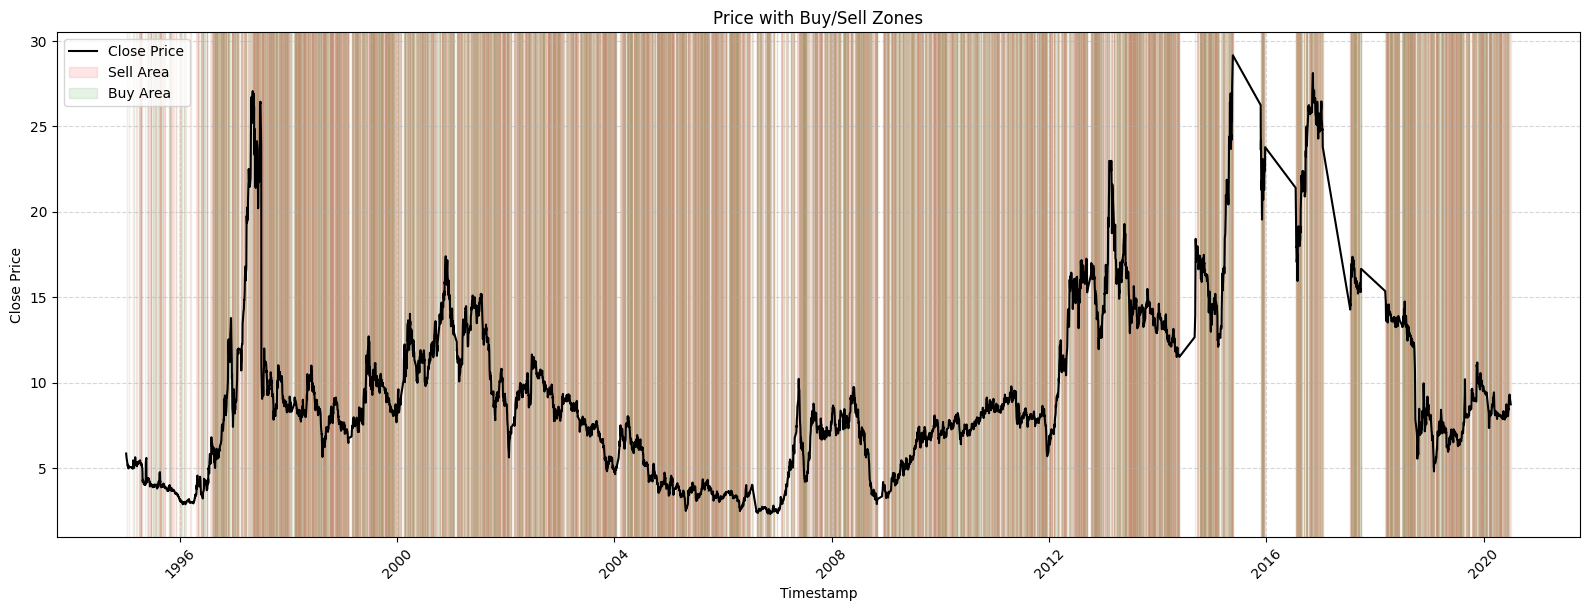

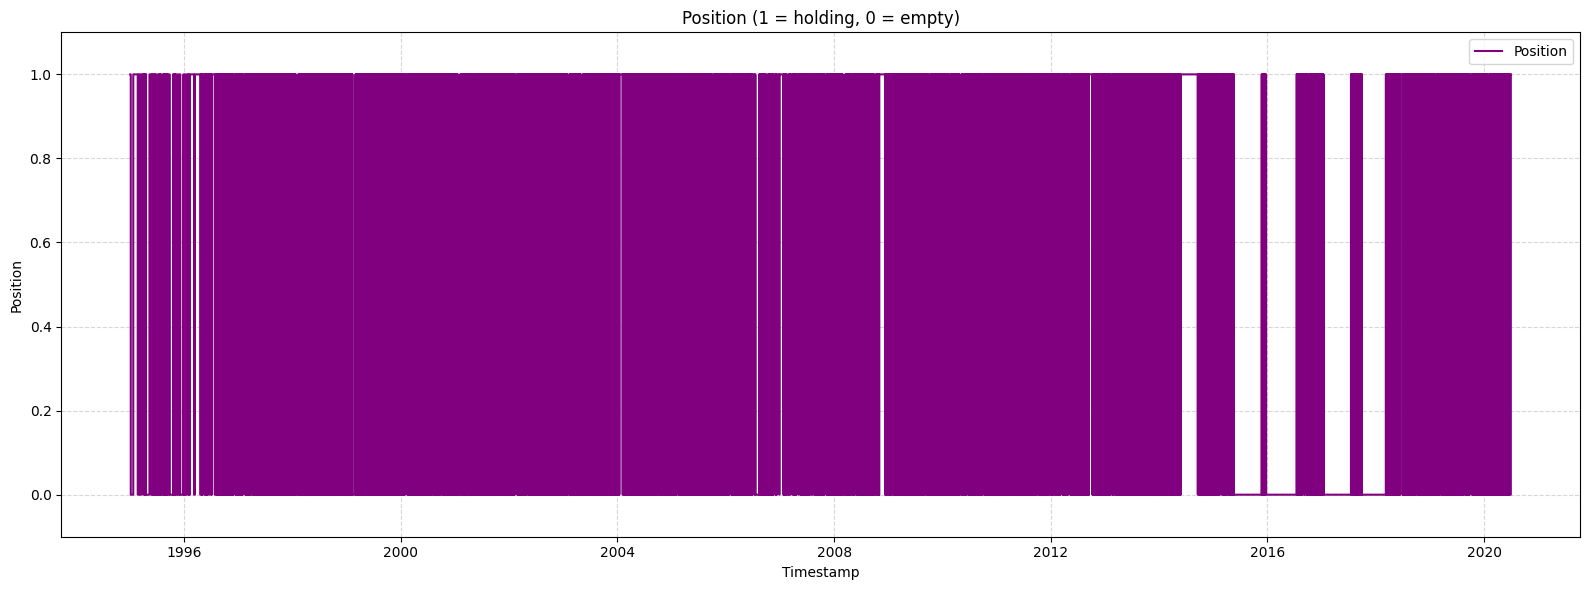

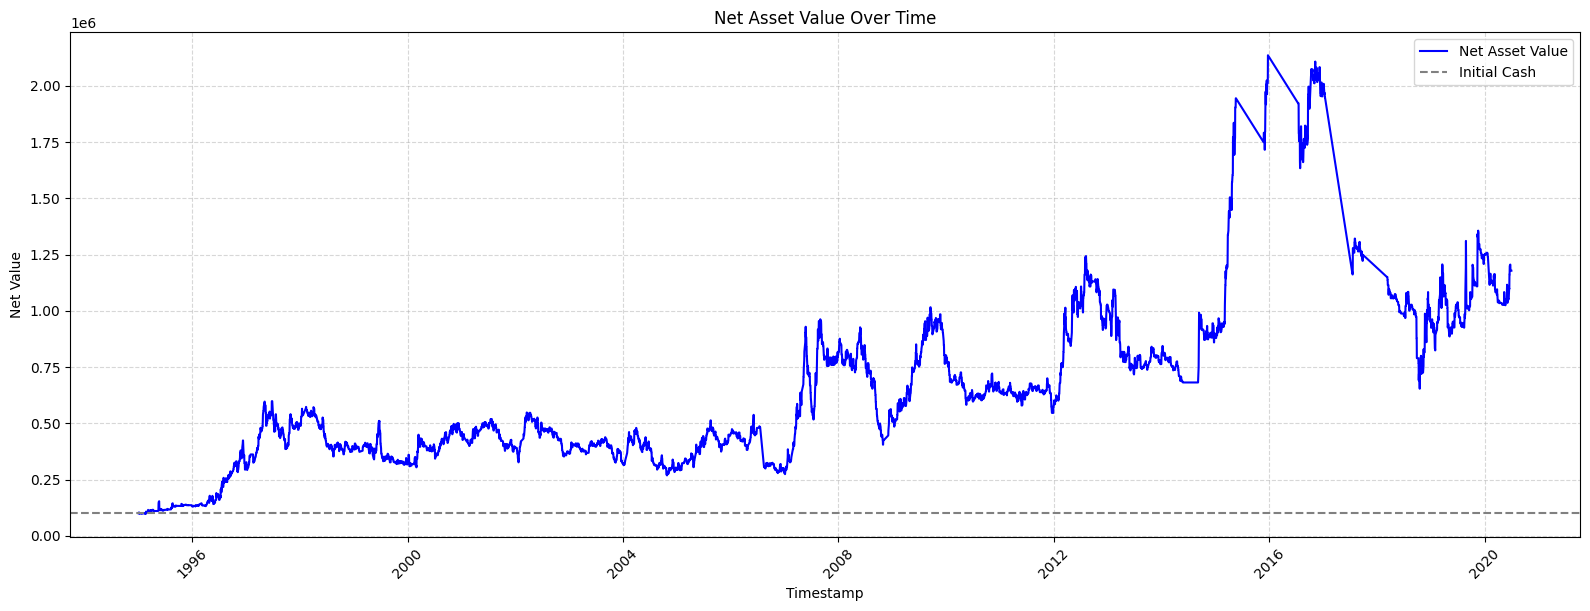

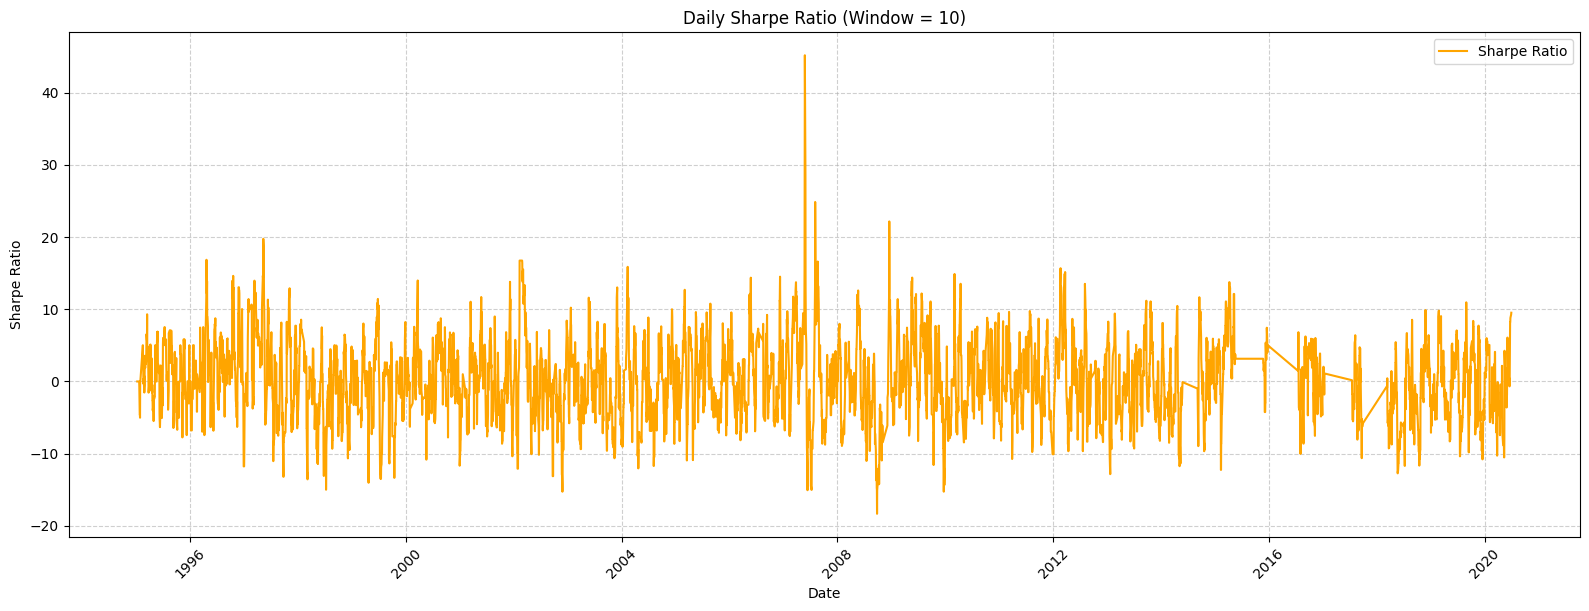

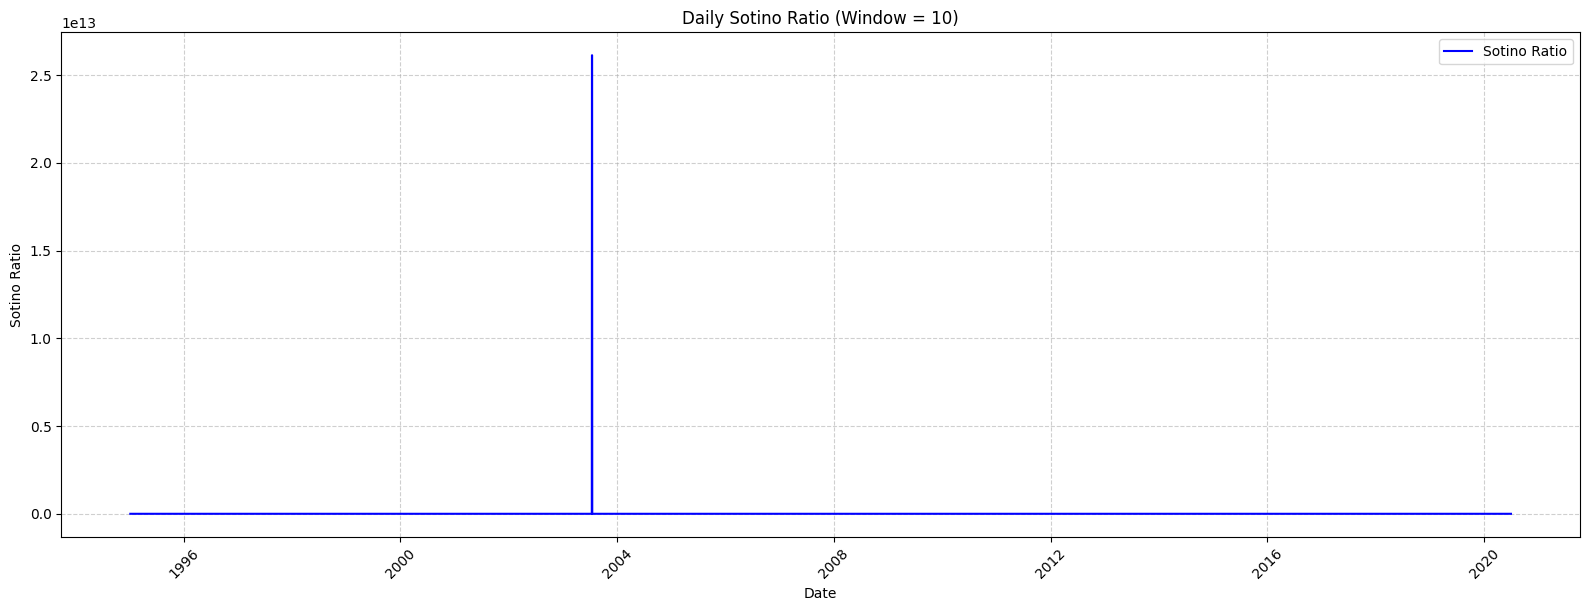

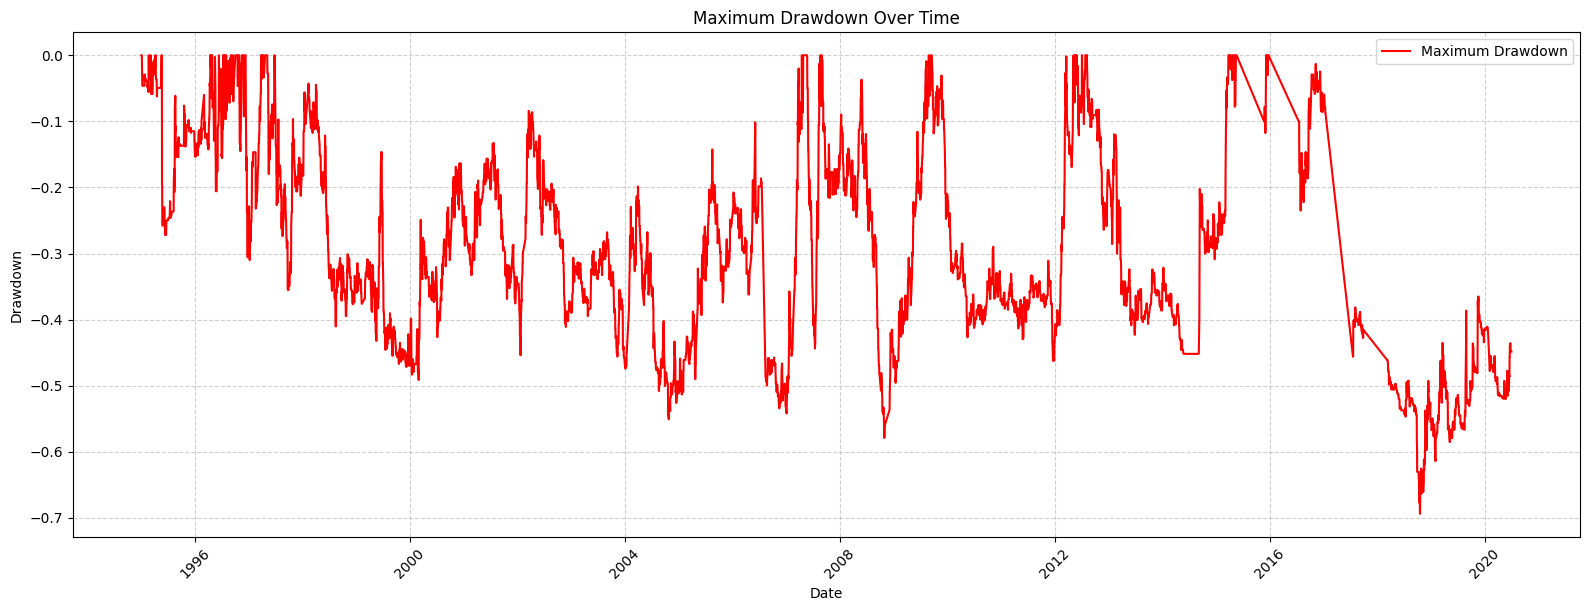

In [18]:
plot_price_actions(train_data, env)
plot_positions(train_data, env)
plot_net_value(train_data, env)
plot_daily_sharpe_ratio(env)
plot_daily_sotino_ratio(env)
plot_max_drawdown(env)

In [19]:
validation_env = QTradingEnv(validation_data)
validation_state = validation_env.reset()
validation_total_reward = 0
validation_actions = []
validation_prices = []
validation_timesstamps = []

while not validation_env.done:
    action = agent.choose_action(validation_state, learn=False)  # 禁用探索，纯用策略
    next_state, reward, done = validation_env.step(action)
    validation_total_reward += reward
    validation_state = next_state

#     # 保存操作用于绘图或分析
    validation_actions.append(action)
    validation_prices.append(validation_env.df.loc[validation_env.current_step - 1, 'close'])
    validation_timesstamps.append(validation_env.df.loc[validation_env.current_step - 1, 'timestamp'])

print(f"✅ 总验证收益: {total_reward:.2f}")

✅ 总验证收益: 1133645661.39


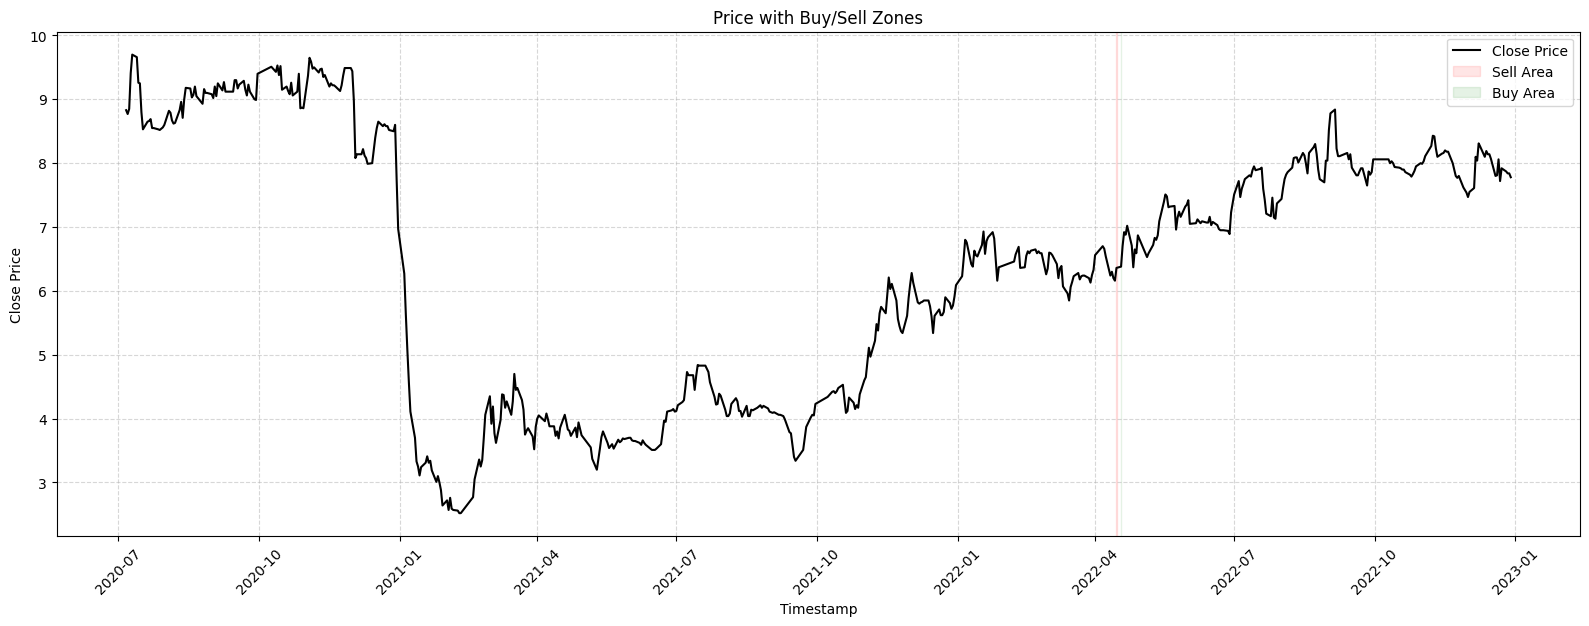

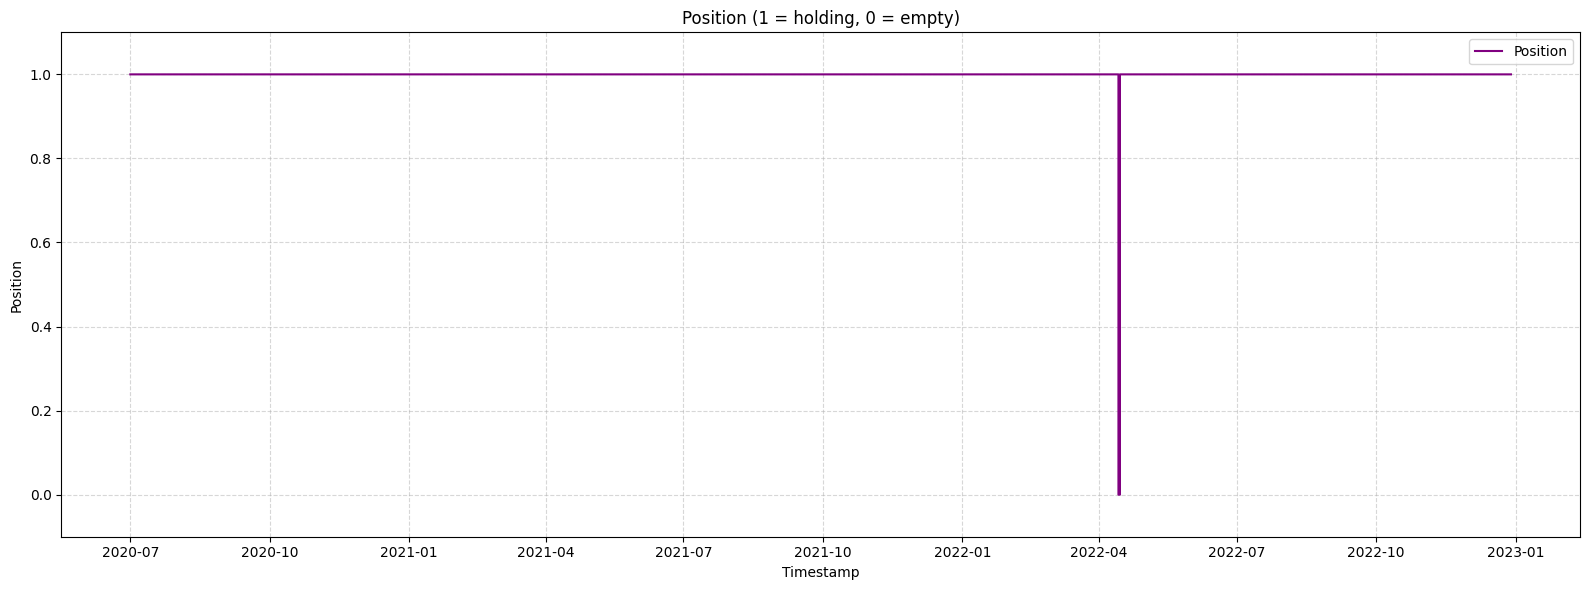

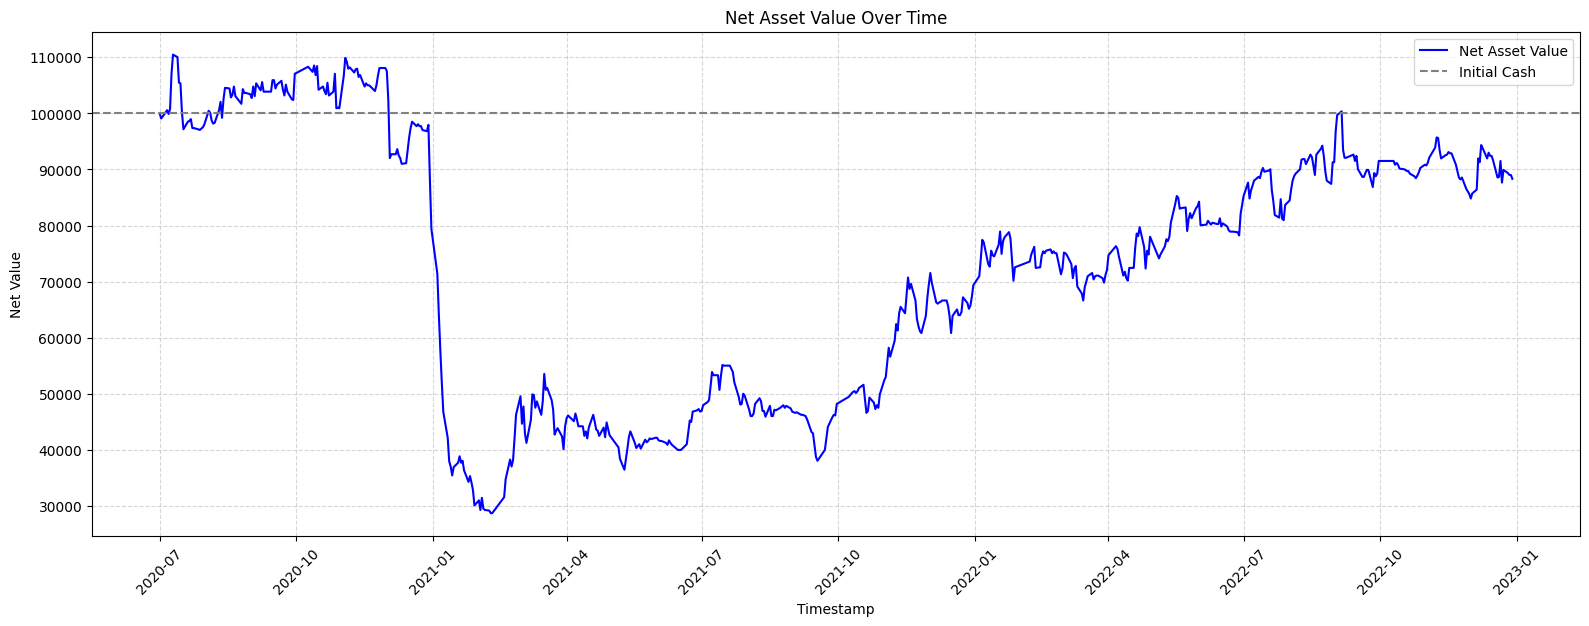

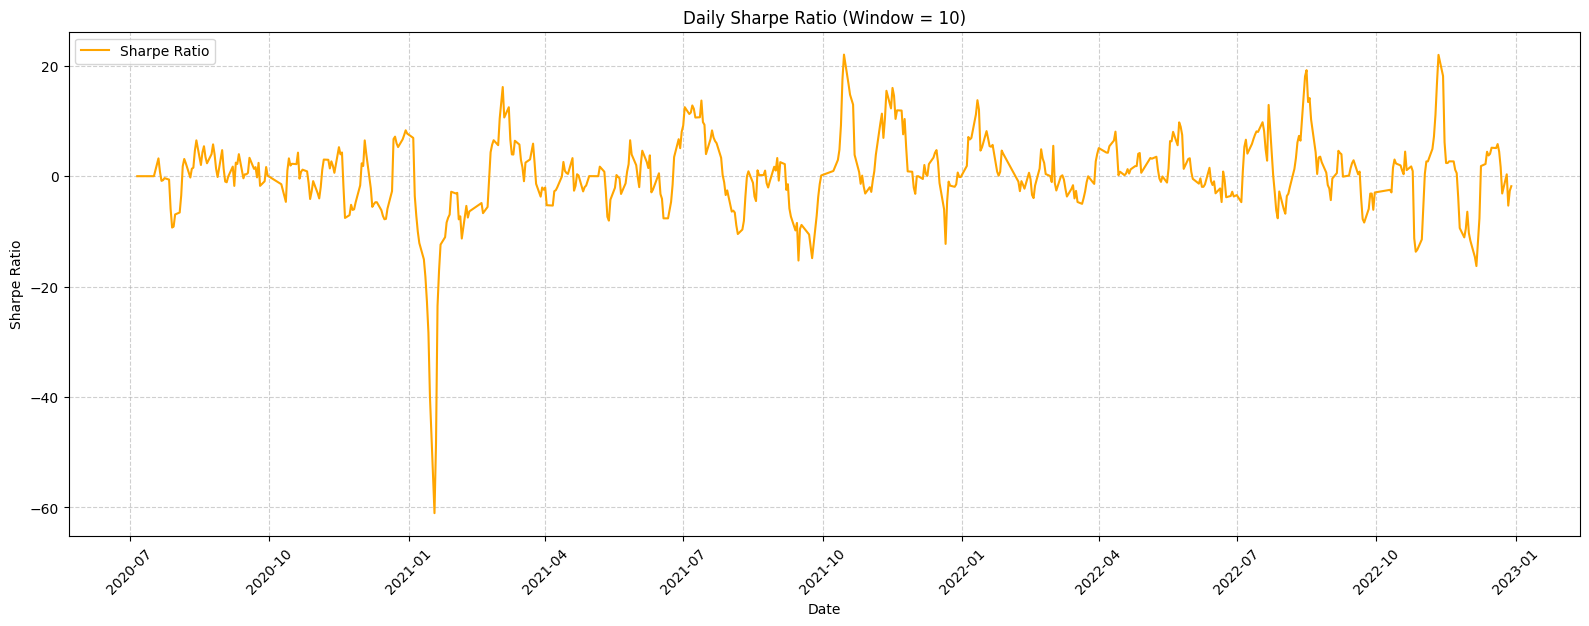

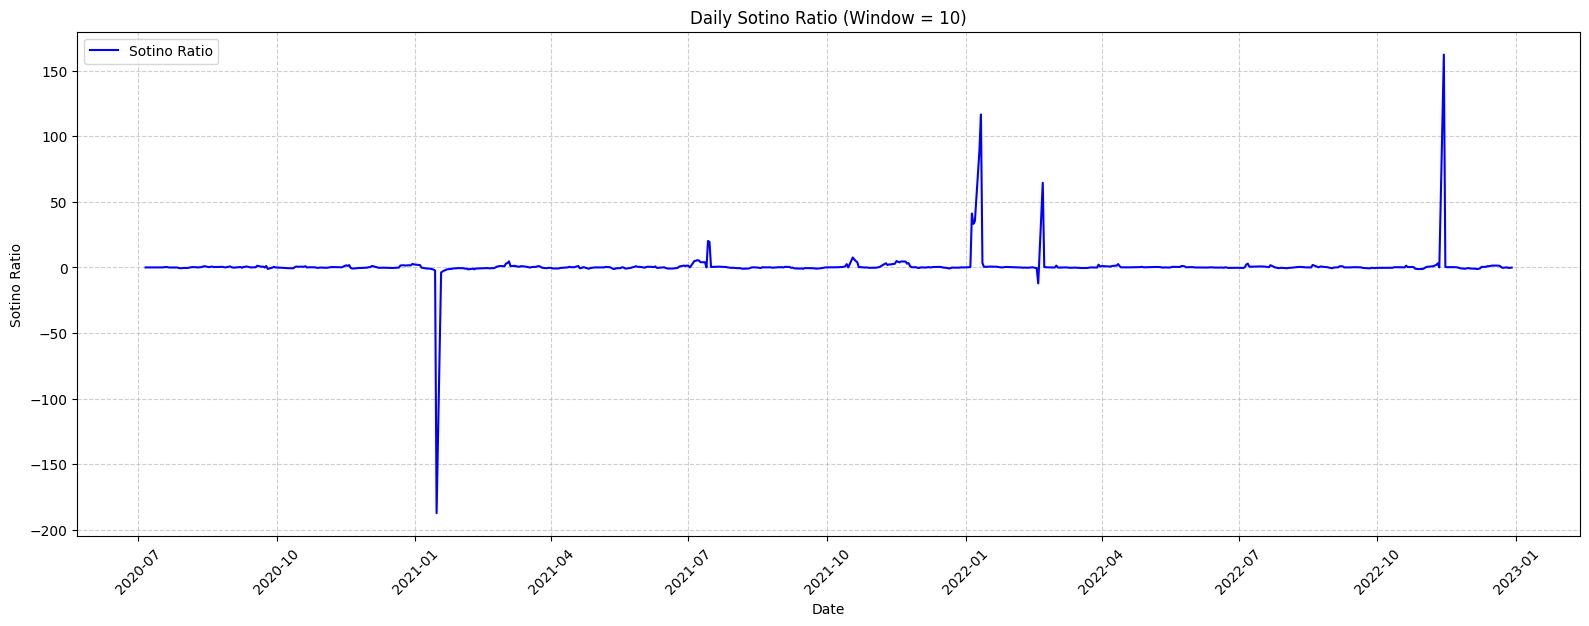

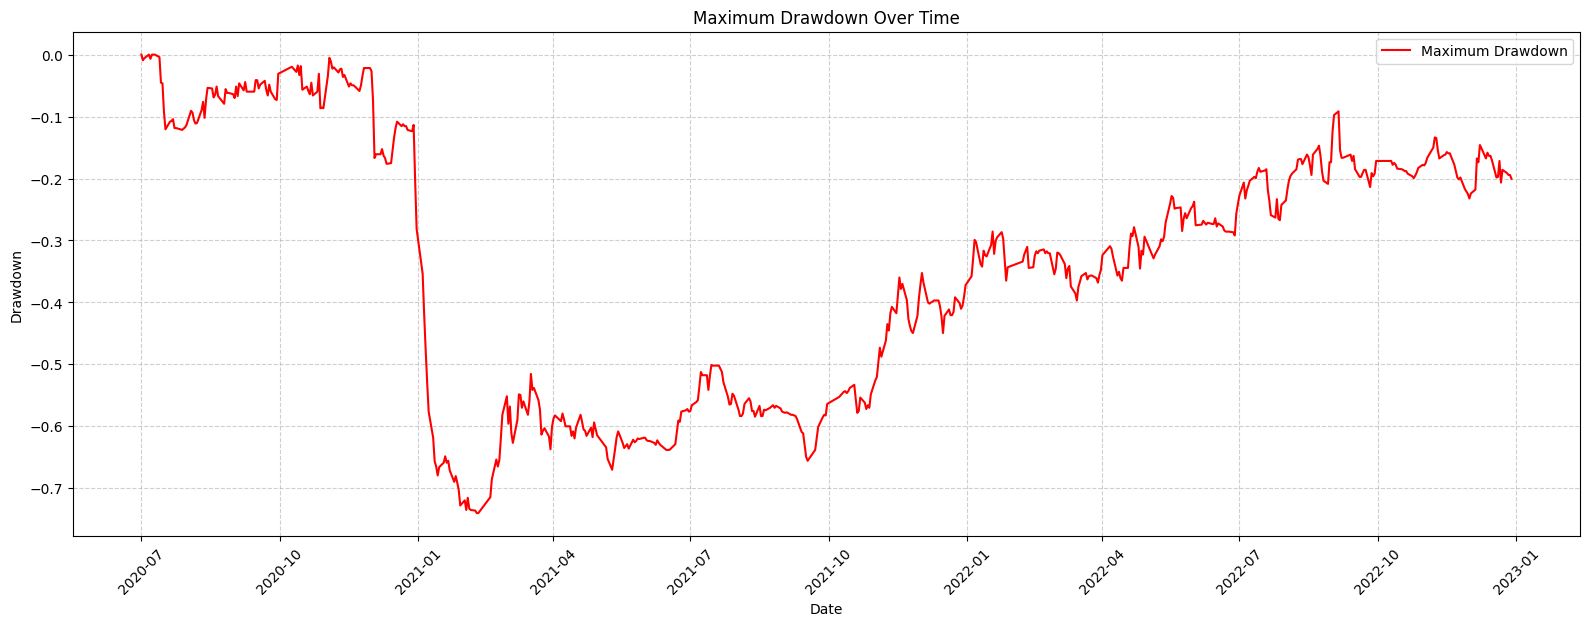

In [20]:
plot_price_actions(validation_data, validation_env)
plot_positions(validation_data, validation_env)
plot_net_value(validation_data, validation_env)
plot_daily_sharpe_ratio(validation_env)
plot_daily_sotino_ratio(validation_env)
plot_max_drawdown(validation_env)